# Import Packages

In [1]:
from typing import TypedDict, Annotated, Dict, List, Sequence
import operator
import json
import pandas as pd

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough
from langchain.memory import ConversationSummaryBufferMemory
from transformers import AutoTokenizer, AutoModelForCausalLM

In [2]:
# from langchain_upstage import UpstageGroundednessCheck
# from langchain_core.documents import Document
# from langchain.chains import LLMChain
# from langchain_core.output_parsers import StrOutputParser
# from langchain_community.tools.tavily_search import TavilySearchResults
# from rag.utils import format_docs, format_searched_docs

# Define State

In [3]:
# 딕셔너리 병합 함수
def merge_dicts(dict1, dict2):
    merged = dict1.copy()  # dict1을 복사하여 새로운 딕셔너리를 생성
    merged.update(dict2)   # dict2의 키와 값을 병합
    return merged

In [4]:
class GraphState(TypedDict):
    question: Annotated[str, operator.add]  # 사용자의 입력질문
    keywords: Annotated[Dict[str, str], merge_dicts]#operator.add]  # 입력질문으로 뽑아낸 키워드
    sql_query: Annotated[str, operator.add]  # 키워드를 기반으로 db 조회하는 쿼리
    db_context: Annotated[Dict[str, str], merge_dicts]#operator.add]  # 뽑힌 여행지들
    answer: Annotated[Dict[str, str], merge_dicts]  # gpt의 대답
    binary_score: Annotated[str, operator.add]  # 검증

# Define Nodes

In [5]:
def chain_start(state: GraphState) -> GraphState:
    # 입력질문을 바탕으로 GPT 수행해서 경향성 키워드 뽑아냄
    prompt = ChatPromptTemplate.from_messages([
    ("system", """너는 의도분석기야. human의 입력을 통해서 [여행일수, 여행하는 사람수, 원하는 여행타입]의 3가지 키워드를 추출해야하고 다음과 같이 json의 형태로 반환해야해.
            여행일수 : 여행일수(몇박을 제외한 n일의 형태), 사람수 : 사람수(숫자만), 여행타입 : 원하는 여행타입(명사로 추출)
            만약 없다면 그 값을 각각 일수는 '3일', 사람수 '2명', 여행타입은 '관광'로 설정해. 만약 친구들, 가족들 이라는 단어가 있다면 사람수는 '4명' 으로 설정해.
            보통 사람들은 ~할거야 또는 ~하고싶어 라고 하면 ~가 여행타입이야. 여행타입은 명사로 추출해야해.
            """),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{question}"),
    ])
    api_key = 'NONE'
    # model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-3.5-turbo")
    model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-4o-mini")
    # 메모리 설정
    memory = ConversationSummaryBufferMemory(
        llm=model,
        max_token_limit=80,
        memory_key="chat_history",
        return_messages=True,
    )

    # 메모리 로드 함수
    def load_memory(input):
        print(input)
        return memory.load_memory_variables({})["chat_history"]

    # 체인 설정
    chain = RunnablePassthrough.assign(chat_history=load_memory) | prompt | model

    # 체인 호출 함수
    def invoke_chain(question):
        result = chain.invoke({"question": question})
        memory.save_context(
            {"input": question},
            {"output": result.content},
        )

        # content 값을 JSON으로 파싱하기 전에 백틱과 불필요한 문자를 제거
        content_str = result.content.strip().strip('```json').strip('```').strip()

        # content 값을 JSON으로 파싱하여 딕셔너리로 변환
        content_dict = json.loads(content_str)
        return content_dict

    # 입력 받기
    question = state['question']
    #start_input = input("안녕! 어떤 여행을 가고 싶어?\t")
    response = invoke_chain(question)

    # keywords = "검색된 키워드들"
    return GraphState(keywords=response)

def db_search(state: GraphState) -> GraphState:
    # db에서 column 검색알고리즘 구현
    keywords = state['keywords']
    n = int(keywords.get('여행일수').replace('일', ''))
    p = int(keywords.get('사람수').replace('명', ''))
    t = keywords.get('여행타입')

    result = {
        "숙박": [],
        "밥집": [],
        "술집": [],
        "관광": []
    }

    data = pd.read_csv('NONE')
    
    # 숙박
    accommodations = data[(data['카테고리'] == '숙박') & (data['사람수'] >= p)]
    sorted_accommodations = accommodations.sort_values(by='추천수', ascending=False)
    result['숙박'] = sorted_accommodations.head(n * 3)['장소명'].tolist()
    
    # 식당
    restaurants = data[(data['카테고리'] == '식당') & (data['사람수'] >= p)]
    rice_restaurants = restaurants[restaurants['특이사항'] == '밥'].sort_values(by='추천수', ascending=False)
    alcohol_restaurants = restaurants[restaurants['특이사항'] == '술'].sort_values(by='추천수', ascending=False)
    result['밥집'] = rice_restaurants.head(n * 6)['장소명'].tolist()
    result['술집'] = alcohol_restaurants.head(n * 3)['장소명'].tolist()
    
    # 관광
    tourism = data[(data['카테고리'] == '관광') & (data['사람수'] >= p) & (data['특이사항'].str.contains(t))]
    sorted_tourism = tourism.sort_values(by='추천수', ascending=False)
    result['관광'] = sorted_tourism.head(n * 6)['장소명'].tolist()

    return GraphState(db_context=result)

#def rewrite_query(state: GraphState) -> GraphState:
#    # query 재작성 구현
#    documents = "검색된 여행지들"
#    return GraphState(db_context=documents)

def gpt_start(state: GraphState) -> GraphState:
    # gpt model loading

    # load parameters
    keywords = state['keywords']
    n = int(keywords.get('여행일수').replace('일', ''))
    places = state['db_context']

    # 입력질문을 바탕으로 GPT 수행해서 경향성 키워드 뽑아냄
    prompt_trip = ChatPromptTemplate.from_messages([
    ("system", """너는 여행 일정 생성기야. 주어진 데이터를 사용하여 n일 동안의 여행 일정을 구성해서 json의 형태로 변환해야 해.
                        여행 일정은 다음과 같은 구조를 따라야 해:
                        - 각 일자의 여행지에는 아침, 점심(아침과 점심은 무조건 밥집), 저녁(저녁은 술집이나 식당)으로 구성되어 있어.
                        - 각 일차에는 2개씩의 관광지가 포함될 거야.
                        - 각 밤마다 숙소가 다른 곳으로 1곳씩 배정되거나 1숙소를 최대 3일동안 같은 곳으로 이용할 수 있어.
                        - 여행 일정의 시작에는 부산역에서 하루를 시작하되, 관광지에는 포함하지 않고, 마지막 날에는 숙소가 포함되지 않고 다시 부산역으로 종착지가 설정돼.
                        - 이 일정 계획은 출력할 때마다 조금씩 다르면 좋을 것 같아. dict 내에서 랜덤으로 뽑아서 일정을 구성해줘.
                        - 이 때 이 각 하루의 일정을 n일차를 키값으로 삼고 여행 일정 순서대로 할당된 value로 해서 dict형태로 만들거야.
                        - 마지막 날엔 숙소를 포함하지 않아.
                        - 다른 메시지는 전혀 출력하지 말고 json만 반환해.
                        """),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{places}의 데이터를 활용해서 {n}일 동안의 일정을 생성해줘."),
    ])
    api_key = 'NONE'
    # model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-3.5-turbo")
    model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-4o-mini")
    # 메모리 설정
    memory = ConversationSummaryBufferMemory(
        llm=model,
        max_token_limit=80,
        memory_key="chat_history",
        return_messages=True,
    )

    # 메모리 로드 함수
    def load_memory(input):
        print(input)
        return memory.load_memory_variables({})["chat_history"]

    # 체인 설정
    chain = RunnablePassthrough.assign(chat_history=load_memory) | prompt_trip | model

    # 체인 호출 함수
    def invoke_chain(n, places):
        result = chain.invoke({"places": json.dumps(places, ensure_ascii=False), 'n': n})
        memory.save_context(
            {"input": json.dumps(places, ensure_ascii=False)},
            {"output": result.content},
        )
        # print(f"result! : {result}")

        # content 값을 JSON으로 파싱하기 전에 백틱과 불필요한 문자를 제거
        content_str = result.content.strip().strip('```json').strip('```').strip()

        # content 값을 JSON으로 파싱하여 딕셔너리로 변환
        content_dict = json.loads(content_str)
        return content_dict

    schedule = invoke_chain(n, places)

    # answer = "GPT 답변"
    return GraphState(answer=schedule)

def llama_start(state: GraphState) -> GraphState:
    # llama model loading
    answer = "Llama 답변"
    return GraphState(answer=answer)

def relevance_check(state: GraphState) -> GraphState:
    # 관련성 확인
    binary_score = "Score"
    return GraphState(binary_score=binary_score)

def sum_up(state: GraphState) -> GraphState:
    # calculate sum
    answer = "답변"
    return GraphState(answer=answer)

# Define Graph

In [6]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

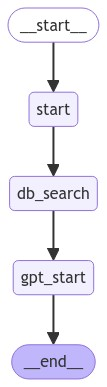

In [7]:
# (1) Conventional RAG
# (2) Re-Search
# (3) Multi LLM
# (4) Re-write Query

# get StateGraph & END from langgraph.graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node('start', chain_start)
workflow.add_node("db_search", db_search)
#workflow.add_node("rewrite_query", rewrite_query) # (4)

workflow.add_node("gpt_start", gpt_start)
#workflow.add_node("llama_start", llama_start) # (3)

#workflow.add_node("gpt_check", relevance_check)
#workflow.add_node("llama_check", relevance_check) # (3)

#workflow.add_node("sum", sum_up)

# Link Nodes
workflow.add_edge('start', 'db_search')
workflow.add_edge("db_search", "gpt_start")
#workflow.add_edge("db_search", "llama_start") # (3)
#workflow.add_edge("rewrite_query", "db_search") # (4)
#workflow.add_edge("gpt_start", "gpt_check")
#workflow.add_edge("gpt_check", "sum")
#workflow.add_edge("llama_start", "llama_check")
#workflow.add_edge("llama_check", "sum") # (3)

#workflow.add_edge("sum", END) # (2) - off
workflow.add_edge("gpt_start", END)
'''
# Add Conditional Edges
workflow.add_conditional_edges(
    "sum", # 관련 체크의 결과를 is_relevant 함수에 전달
    decision,
    {
        "to_research" : "db_search", # 재검색
        "to_end" : END, # 종료
    },
)
'''
# Add Conditional Edges
'''
workflow.add_conditional_edges(
    "sum", # 관련 체크의 결과를 is_relevant 함수에 전달
    decision,
    {
        "to_research" : "rewrite_query", # 재검색
        "to_end" : END, # 종료
    },
)'''

# Set Start Point
workflow.set_entry_point("start")

# Set Memory for Log
memory = MemorySaver()

# Compile Graph
app = workflow.compile(checkpointer=memory)

try:
    display(
        Image(app.get_graph(xray = True).draw_mermaid_png())
    ) # 실행 가능한 객체 그래프를 mermaid 형식의 PNG로 그려줌
    # xray = True -> 추가 세부 정보 포함
except:
    # 이 부분은 추가적인 의존성 필요, 선택적 실행
    pass


# Test 공간

In [8]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig


In [9]:
# Test 수행코드
config = RunnableConfig(
    recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
)
q = input("반갑습니다!")
inputs = GraphState(question=q)
# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            # 출력 값을 예쁘게 출력합니다.
            pprint.pprint(value, indent=2, width=80, depth=None)
        # 각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

{'question': '3일 여행코스 짜줘. 혼자 조용한 여행할거야'}
"Output from node 'start':"
'---'
{'keywords': {'사람수': '1명', '여행일수': '3일', '여행타입': '조용한 여행'}}
'\n---\n'
"Output from node 'db_search':"
'---'
{ 'db_context': { '관광': [],
                  '밥집': [ '고소한치킨집',
                          '향긋한포차',
                          '향긋한치킨집',
                          '달콤한포차',
                          '악마김밥',
                          '바삭한김밥천국',
                          '혼밥전문점',
                          '달콤한분식점',
                          '얼큰한찜질방',
                          '삼삼뼈국',
                          '바삭한피자집',
                          '바삭한횟집',
                          '매운치킨집',
                          '바삭한피자집',
                          '맛있는횟집',
                          '혼자와도추천두번',
                          '청년김밥',
                          '맛없는식당'],
                  '숙박': [ '롯데호텔',
                          '아늑한게스트하우스',
                          '고급스러운펜션',
                          '저렴한모텔',
     

In [10]:
print(output)

{'gpt_start': {'answer': {'1일차': {'아침': '고소한치킨집', '점심': '바삭한김밥천국', '저녁': '혼술의성지', '관광지': ['관광지1', '관광지2'], '숙소': '롯데호텔'}, '2일차': {'아침': '달콤한분식점', '점심': '얼큰한찜질방', '저녁': '매운삼겹살집', '관광지': ['관광지3', '관광지4'], '숙소': '아늑한게스트하우스'}, '3일차': {'아침': '악마김밥', '점심': '삼삼뼈국', '저녁': '매운김밥천국', '관광지': ['관광지5', '관광지6']}}}}


### 실제 수행코드여야함

In [ ]:
config = RunnableConfig(
    recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
)

# AgentState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(
    question=input("gpt를 시작하세요 : ")
)
#print(app.stream(inputs, config=config))

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            # 출력 값을 예쁘게 출력합니다.
            pprint.pprint(value, indent=2, width=80, depth=None)
        # 각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")


# Test 및 실험공간

In [4]:
# 입력질문을 바탕으로 GPT 수행해서 경향성 키워드 뽑아냄
prompt1 = ChatPromptTemplate.from_messages([
("system", """너는 의도분석기야. human의 입력을 통해서 [여행일수, 여행하는 사람수, 원하는 여행타입]의 3가지 키워드를 추출해야하고 다음과 같이 json의 형태로 반환해야해.
            여행일수 : 여행일수(몇박을 제외한 n일의 형태), 사람수 : 사람수(숫자만), 여행타입 : 원하는 여행타입(명사로 추출)
            만약 없다면 그 값을 각각 일수는 '2일', 사람수 '2명', 여행타입은 '관광'로 설정해.
            보통 사람들은 ~할거야 또는 ~하고싶어 라고 하면 ~가 여행타입이야. 여행타입은 명사로 추출해야해.
        """),
MessagesPlaceholder(variable_name="chat_history"),
("human", "{question}"),
])
api_key = 'NONE'
# model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-3.5-turbo")
model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-4o-mini")
# 메모리 설정
memory = ConversationSummaryBufferMemory(
    llm=model,
    max_token_limit=80,
    memory_key="chat_history",
    return_messages=True,
)

# 메모리 로드 함수
def load_memory(input):
    print(input)
    return memory.load_memory_variables({})["chat_history"]

# 체인 설정
chain = RunnablePassthrough.assign(chat_history=load_memory) | prompt1 | model

# 체인 호출 함수
def invoke_chain(question):
    result = chain.invoke({"question": question})
    memory.save_context(
        {"input": question},
        {"output": result.content},
    )

    # content 값을 JSON으로 파싱하기 전에 백틱과 불필요한 문자를 제거
    content_str = result.content.strip().strip('```json').strip('```').strip()

    # content 값을 JSON으로 파싱하여 딕셔너리로 변환
    content_dict = json.loads(content_str)
    return content_dict

# 입력 받기
start_input = input("Hi! What can i help you?\t")
response = invoke_chain(start_input)

{'question': '부산으로 3박4일 친구들이랑 여행가려고'}


In [5]:
response

{'여행일수': '4일', '사람수': '3명', '여행타입': '여행'}

In [8]:
# db에서 column 검색알고리즘 구현
keywords = response
n = int(keywords.get('여행일수').replace('일', ''))
p = int(keywords.get('사람수').replace('명', ''))
t = keywords.get('여행타입')

result = {
    "숙박": [],
    "밥집": [],
    "술집": [],
    "관광": []
}

data = pd.read_csv('NONE')

# 숙박
accommodations = data[(data['카테고리'] == '숙박') & (data['사람수'] >= p)]
sorted_accommodations = accommodations.sort_values(by='추천수', ascending=False)
result['숙박'] = sorted_accommodations.head(n * 3)['장소명'].tolist() # 숙박 필요한 개수 * 3

# 식당
restaurants = data[(data['카테고리'] == '식당') & (data['사람수'] >= p)]
rice_restaurants = restaurants[restaurants['특이사항'] == '밥'].sort_values(by='추천수', ascending=False)
alcohol_restaurants = restaurants[restaurants['특이사항'] == '술'].sort_values(by='추천수', ascending=False)
result['밥집'] = rice_restaurants.head(n * 6)['장소명'].tolist()
result['술집'] = alcohol_restaurants.head(n * 3)['장소명'].tolist() # 밥집은 2개 * 3 + 술집 1개 * 3

# 관광
tourism = data[(data['카테고리'] == '관광') & (data['사람수'] >= p) & (data['특이사항'].str.contains(t))]
sorted_tourism = tourism.sort_values(by='추천수', ascending=False)
result['관광'] = sorted_tourism.head(n * 6)['장소명'].tolist() # 관광 2개 * 3

In [9]:
data

,장소명,사람수,카테고리,추천수,특이사항
0,혼술의성지,1,식당,1000,술
1,혼밥전문점,1,식당,544,밥
2,짝이되고싶나?,2,식당,342,술
3,삼삼뼈국,3,식당,231,밥
4,가족수산,4,식당,233,술
...,...,...,...,...,...
124,부산스파랜드,6,관광,613,"액티비티, 바다"
125,해운대달맞이고개,1,관광,15680,"휴양, 관광"
126,부산국제영화제광장,9,관광,17392,"액티비티, 바다"
127,부산비치타워,3,관광,18461,"액티비티, 바다"


In [10]:
result

{'숙박': ['롯데호텔',
  '아늑한게스트하우스',
  '고급스러운펜션',
  '저렴한모텔',
  '고급스러운게스트하우스',
  '편안한게스트하우스',
  '저렴한호텔',
  '저렴한게스트하우스',
  '아늑한모텔',
  '편안한모텔',
  '아늑한펜션',
  '아늑한펜션'],
 '밥집': ['고소한치킨집',
  '향긋한포차',
  '향긋한치킨집',
  '달콤한포차',
  '바삭한김밥천국',
  '달콤한분식점',
  '얼큰한찜질방',
  '삼삼뼈국',
  '바삭한피자집',
  '매운치킨집',
  '바삭한피자집',
  '맛있는횟집',
  '혼자와도추천두번',
  '청년김밥'],
 '술집': ['얼큰한김밥천국',
  '고소한횟집',
  '바삭한식당',
  '향긋한김밥천국',
  '얼큰한분식점',
  '달콤한찜질방',
  '얼큰한횟집',
  '매운포차',
  '가족수산',
  '훈훈한피자집',
  '신선한식당',
  '향긋한삼겹살집'],
 '관광': []}

In [ ]:
# JSON 파일로 저장
with open('output.json', 'w', encoding='utf-8') as json_file:
    json.dump(result, json_file, ensure_ascii=False, indent=4)

In [11]:
keywords = response
n = int(keywords.get('여행일수').replace('일', ''))
places = result

# 입력질문을 바탕으로 GPT 수행해서 경향성 키워드 뽑아냄
prompt_trip = ChatPromptTemplate.from_messages([
("system", """너는 여행 일정 생성기야. 주어진 데이터를 사용하여 n일 동안의 여행 일정을 구성해서 json의 형태로 변환해야 해.
                     여행 일정은 다음과 같은 구조를 따라야 해:
                     - 각 일자의 여행지에는 아침, 점심(아침과 점심은 무조건 밥집), 저녁(저녁은 술집이나 식당)으로 구성되어 있어.
                     - 각 일차에는 2개씩의 관광지가 포함될 거야.
                     - 각 밤마다 숙소가 다른 곳으로 1곳씩 배정되거나 1숙소를 최대 3일동안 같은 곳으로 이용할 수 있어.
                     - 여행 일정의 시작에는 부산역에서 하루를 시작하되, 관광지에는 포함하지 않고, 마지막 날에는 숙소가 포함되지 않고 다시 부산역으로 종착지가 설정돼.
                     - 이 일정 계획은 출력할 때마다 조금씩 다르면 좋을 것 같아. dict 내에서 랜덤으로 뽑아서 일정을 구성해줘.
                     - 이 때 이 각 하루의 일정을 n일차를 키값으로 삼고 여행 일정 순서대로 할당된 value로 해서 dict형태로 만들거야.
                     - 마지막 날엔 숙소를 포함하지 않아.
                     - 다른 메시지는 전혀 출력하지 말고 json만 반환해.
                     """),
MessagesPlaceholder(variable_name="chat_history"),
("human", "{places}의 데이터를 활용해서 {n}일 동안의 일정을 생성해줘."),
])
api_key = 'NONE'
# model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-3.5-turbo")
model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-4o-mini")
# 메모리 설정
memory = ConversationSummaryBufferMemory(
    llm=model,
    max_token_limit=80,
    memory_key="chat_history",
    return_messages=True,
)

# 메모리 로드 함수
def load_memory(input):
    print(input)
    return memory.load_memory_variables({})["chat_history"]

# 체인 설정
chain = RunnablePassthrough.assign(chat_history=load_memory) | prompt_trip | model

# 체인 호출 함수
def invoke_chain(n, places):
    result = chain.invoke({"places": json.dumps(places, ensure_ascii=False), 'n': n})
    memory.save_context(
        {"input": json.dumps(places, ensure_ascii=False)},
        {"output": result.content},
    )
    print(f"result! : {result}")

    # content 값을 JSON으로 파싱하기 전에 백틱과 불필요한 문자를 제거
    content_str = result.content.strip().strip('```json').strip('```').strip()

    # content 값을 JSON으로 파싱하여 딕셔너리로 변환
    content_dict = json.loads(content_str)
    return content_dict

schedule = invoke_chain(n, places)

{'places': '{"숙박": ["롯데호텔", "아늑한게스트하우스", "고급스러운펜션", "저렴한모텔", "고급스러운게스트하우스", "편안한게스트하우스", "저렴한호텔", "저렴한게스트하우스", "아늑한모텔", "편안한모텔", "아늑한펜션", "아늑한펜션"], "밥집": ["고소한치킨집", "향긋한포차", "향긋한치킨집", "달콤한포차", "바삭한김밥천국", "달콤한분식점", "얼큰한찜질방", "삼삼뼈국", "바삭한피자집", "매운치킨집", "바삭한피자집", "맛있는횟집", "혼자와도추천두번", "청년김밥"], "술집": ["얼큰한김밥천국", "고소한횟집", "바삭한식당", "향긋한김밥천국", "얼큰한분식점", "달콤한찜질방", "얼큰한횟집", "매운포차", "가족수산", "훈훈한피자집", "신선한식당", "향긋한삼겹살집"], "관광": []}', 'n': 4}
result! : content='```json\n{\n    "1일차": {\n        "관광지": ["관광지1", "관광지2"],\n        "식사": {\n            "아침": "고소한치킨집",\n            "점심": "향긋한포차",\n            "저녁": "얼큰한김밥천국"\n        },\n        "숙소": "롯데호텔"\n    },\n    "2일차": {\n        "관광지": ["관광지3", "관광지4"],\n        "식사": {\n            "아침": "바삭한김밥천국",\n            "점심": "달콤한분식점",\n            "저녁": "고소한횟집"\n        },\n        "숙소": "아늑한게스트하우스"\n    },\n    "3일차": {\n        "관광지": ["관광지5", "관광지6"],\n        "식사": {\n            "아침": "얼큰한찜질방",\n            "점심": "삼삼뼈국",\n            "저녁": "바삭한식

In [12]:
schedule

{'1일차': {'관광지': ['관광지1', '관광지2'],
  '식사': {'아침': '고소한치킨집', '점심': '향긋한포차', '저녁': '얼큰한김밥천국'},
  '숙소': '롯데호텔'},
 '2일차': {'관광지': ['관광지3', '관광지4'],
  '식사': {'아침': '바삭한김밥천국', '점심': '달콤한분식점', '저녁': '고소한횟집'},
  '숙소': '아늑한게스트하우스'},
 '3일차': {'관광지': ['관광지5', '관광지6'],
  '식사': {'아침': '얼큰한찜질방', '점심': '삼삼뼈국', '저녁': '바삭한식당'},
  '숙소': '고급스러운펜션'},
 '4일차': {'관광지': ['관광지7', '관광지8'],
  '식사': {'아침': '매운치킨집', '점심': '청년김밥', '저녁': '훈훈한피자집'}}}

## 각 노드 구성공간

### chain start
- 입력을 받고 사용자의 입력에서 db검색을 위한 키워드를 추출하는 단계

In [ ]:
def chain_start(state: GraphState) -> GraphState:
    # 입력질문을 바탕으로 GPT 수행해서 경향성 키워드 뽑아냄
    prompt = ChatPromptTemplate.from_messages([
    ("system", """너는 의도분석기야. human의 입력을 통해서 [여행일수, 여행하는 사람수, 원하는 여행타입]의 3가지 키워드를 추출해야하고 다음과 같이 json의 형태로 반환해야해.
            여행일수 : 여행일수(몇박을 제외한 n일의 형태), 사람수 : 사람수(숫자만), 여행타입 : 원하는 여행타입(명사로 추출)
            만약 없다면 그 값을 각각 일수는 '2일', 사람수 '2명', 여행타입은 '관광'로 설정해.
            보통 사람들은 ~할거야 또는 ~하고싶어 라고 하면 ~가 여행타입이야. 여행타입은 명사로 추출해야해.
            """),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{question}"),
    ])
    api_key = 'NONE'
    # model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-3.5-turbo")
    model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-4o-mini")
    # 메모리 설정
    memory = ConversationSummaryBufferMemory(
        llm=model,
        max_token_limit=80,
        memory_key="chat_history",
        return_messages=True,
    )

    # 메모리 로드 함수
    def load_memory(input):
        print(input)
        return memory.load_memory_variables({})["chat_history"]

    # 체인 설정
    chain = RunnablePassthrough.assign(chat_history=load_memory) | prompt | model

    # 체인 호출 함수
    def invoke_chain(question):
        result = chain.invoke({"question": question})
        memory.save_context(
            {"input": question},
            {"output": result.content},
        )

        # content 값을 JSON으로 파싱하기 전에 백틱과 불필요한 문자를 제거
        content_str = result.content.strip().strip('```json').strip('```').strip()

        # content 값을 JSON으로 파싱하여 딕셔너리로 변환
        content_dict = json.loads(content_str)
        return content_dict

    # 입력 받기
    start_input = input("안녕! 어떤 여행을 가고 싶어?\t")
    response = invoke_chain(start_input)

    # keywords = "검색된 키워드들"
    return GraphState(keywords=response)

### db_search
- db에서 검색을 수행하는 단계
- 키워드를 통해 검색을 하고 Top-K의 여행지, 숙박업소, 식당을 추출한다

In [ ]:
import pandas as pd

In [ ]:
# Test DF Define
test_df = pd.read_csv('NONE')

In [ ]:
def db_search(state: GraphState) -> GraphState:
    # db에서 column 검색알고리즘 구현
    keywords = state['keywords']
    n = int(keywords.get('여행일수'))
    p = int(keywords.get('사람수'))
    t = keywords.get('여행타입')

    result = {
        "숙박": [],
        "밥집": [],
        "술집": [],
        "관광": []
    }

    data = pd.read_csv('NONE')
    
    # 숙박
    accommodations = data[(data['카테고리'] == '숙박') & (data['사람수'] >= p)]
    sorted_accommodations = accommodations.sort_values(by='추천수', ascending=False)
    result['숙박'] = sorted_accommodations.head(n * 3)['장소명'].tolist()
    
    # 식당
    restaurants = data[(data['카테고리'] == '식당') & (data['사람수'] >= p)]
    rice_restaurants = restaurants[restaurants['특이사항'] == '밥'].sort_values(by='추천수', ascending=False)
    alcohol_restaurants = restaurants[restaurants['특이사항'] == '술'].sort_values(by='추천수', ascending=False)
    result['밥집'] = rice_restaurants.head(n * 6)['장소명'].tolist()
    result['술집'] = alcohol_restaurants.head(n * 3)['장소명'].tolist()
    
    # 관광
    tourism = data[(data['카테고리'] == '관광') & (data['사람수'] >= p) & (data['특이사항'].str.contains(t))]
    sorted_tourism = tourism.sort_values(by='추천수', ascending=False)
    result['관광'] = sorted_tourism.head(n * 6)['장소명'].tolist()

    return GraphState(db_context=result)

### gpt_start
- 추출한 장소들을 기반으로 랜덤하게 여행템플릿을 짜주는 단계
- 프롬프트 엔지니어링이 필요하다

In [ ]:
def gpt_start(state: GraphState) -> GraphState:
    # gpt model loading

    # load parameters
    keywords = response
    n = int(keywords.get('여행일수').replace('일', ''))
    places = db_context

    # 입력질문을 바탕으로 GPT 수행해서 경향성 키워드 뽑아냄
    prompt_trip = ChatPromptTemplate.from_messages([
    ("system", """너는 여행 일정 생성기야. 주어진 데이터를 사용하여 n일 동안의 여행 일정을 구성해서 json의 형태로 변환해야 해.
                        여행 일정은 다음과 같은 구조를 따라야 해:
                        - 각 일자의 여행지에는 아침, 점심(아침과 점심은 무조건 밥집), 저녁(저녁은 술집이나 식당)으로 구성되어 있어.
                        - 각 일차에는 2개씩의 관광지가 포함될 거야.
                        - 각 밤마다 숙소가 다른 곳으로 1곳씩 배정되거나 1숙소를 최대 3일동안 같은 곳으로 이용할 수 있어.
                        - 여행 일정의 시작에는 부산역에서 하루를 시작하되, 관광지에는 포함하지 않고, 마지막 날에는 숙소가 포함되지 않고 다시 부산역으로 종착지가 설정돼.
                        - 이 일정 계획은 출력할 때마다 조금씩 다르면 좋을 것 같아. dict 내에서 랜덤으로 뽑아서 일정을 구성해줘.
                        - 이 때 이 각 하루의 일정을 n일차를 키값으로 삼고 여행 일정 순서대로 할당된 value로 해서 dict형태로 만들거야.
                        - 마지막 날엔 숙소를 포함하지 않아.
                        - 다른 메시지는 전혀 출력하지 말고 json만 반환해.
                        """),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{places}의 데이터를 활용해서 {n}일 동안의 일정을 생성해줘."),
    ])
    api_key = 'NONE'
    # model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-3.5-turbo")
    model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-4o-mini")
    # 메모리 설정
    memory = ConversationSummaryBufferMemory(
        llm=model,
        max_token_limit=80,
        memory_key="chat_history",
        return_messages=True,
    )

    # 메모리 로드 함수
    def load_memory(input):
        print(input)
        return memory.load_memory_variables({})["chat_history"]

    # 체인 설정
    chain = RunnablePassthrough.assign(chat_history=load_memory) | prompt_trip | model

    # 체인 호출 함수
    def invoke_chain(n, places):
        result = chain.invoke({"places": json.dumps(places, ensure_ascii=False), 'n': n})
        memory.save_context(
            {"input": json.dumps(places, ensure_ascii=False)},
            {"output": result.content},
        )
        # print(f"result! : {result}")

        # content 값을 JSON으로 파싱하기 전에 백틱과 불필요한 문자를 제거
        content_str = result.content.strip().strip('```json').strip('```').strip()

        # content 값을 JSON으로 파싱하여 딕셔너리로 변환
        content_dict = json.loads(content_str)
        return content_dict

    schedule = invoke_chain(n, places)

    # answer = "GPT 답변"
    return GraphState(answer=schedule)